In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sherifmagdyabdellah
Your Kaggle Key: ··········


100%|██████████| 26.4M/26.4M [00:00<00:00, 42.8MB/s]


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/entity-annotated-corpus/ner_dataset.csv',encoding='cp1252').to_numpy()
df_pandas = pd.read_csv('/content/entity-annotated-corpus/ner_dataset.csv',encoding='cp1252')


In [4]:
df_pandas.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
labels=np.unique(df_pandas['Tag'])
#labels name
print(f"len= {labels.shape[0]}")
for l in labels:
  print(l)


len= 17
B-art
B-eve
B-geo
B-gpe
B-nat
B-org
B-per
B-tim
I-art
I-eve
I-geo
I-gpe
I-nat
I-org
I-per
I-tim
O


In [6]:
All_sentence=[]
All_pos=[]
All_tag=[]
Sentence=""
Pos=[]
Tag=[]
for row in df:
  if(type(row[0])==str):
    if(Sentence!="" and (len(Pos)==len(Tag)) and (len(Sentence.split())==len(Pos))):
      All_sentence.append(Sentence)
      All_pos.append(Pos)
      All_tag.append(Tag)
    Sentence=""
    Pos=[]
    Tag=[]
    Sentence+=row[1]
    Pos.append(row[2])
    Tag.append(row[3])
  else:
    Sentence+=" "+row[1]
    Pos.append(row[2])
    Tag.append(row[3])



In [7]:
print(f"All sentences count= {len(All_sentence)}")
print(f"All Pos count= {len(All_pos)}")
print(f"All tag count= {len(All_tag)}")
print("they must be equal")

All sentences count= 47957
All Pos count= 47957
All tag count= 47957
they must be equal


In [8]:
print(All_sentence[0].split())
print(All_tag[0])
print(All_pos[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.']


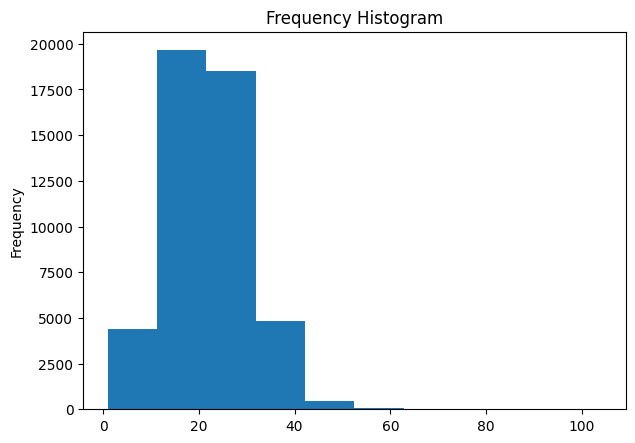

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist([len(i) for i in All_pos])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [10]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 6.9 MB/s 


In [11]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 238 kB 49.7 MB/s 
     |████████████████████████████████| 1.3 MB 51.5 MB/s 
     |████████████████████████████████| 99 kB 10.2 MB/s 
     |████████████████████████████████| 116 kB 68.5 MB/s 
     |████████████████████████████████| 1.1 MB 67.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 352 kB 56.2 MB/s 


In [12]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt



In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 9.5 MB/s 
     |████████████████████████████████| 163 kB 71.6 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 


In [14]:
import transformers
from transformers import BertTokenizerFast


In [25]:
MAX_LENGTH=55
Labels={
    'B-art':16, 'B-eve':15, 'B-geo':14, 'B-gpe':13, 'B-nat':12, 'B-org':11, 'B-per':10,
       'B-tim':9, 'I-art':8, 'I-eve':7, 'I-geo':6, 'I-gpe':5, 'I-nat':4, 'I-org':3,
       'I-per':2, 'I-tim':1, 'O':0
}

In [16]:
def split_into_chuncks(lst,max_length):
  #divide 2 from max_length beacause we will add special tokens [cls],[sep]
  return [lst[i * (max_length-2):(i + 1) * (max_length-2)] for i in range((len(lst) + (max_length-2) - 1) // (max_length-2) )]
def add_padding(lst,max_length):
   return [ i+([0]*(max_length-len(i))) for i in lst]

def preprocessingtokens(All_sentence,All_pos,All_tag,max_length,tag_labels):
  All_ids=[]
  All_final_pos=[]
  All_final_tags=[]
  All_masks=[]
  All_type_ids=[]
  t = BertTokenizerFast.from_pretrained('bert-base-uncased')

  for idx , sentence in enumerate(All_sentence):
    sentences_splited_into_words =All_sentence[idx].split(" ")
    e = t(sentences_splited_into_words, add_special_tokens=False, return_attention_mask=False, return_token_type_ids=False)
    tokens=[]
    Pos=[]
    Tag=[]
    for i ,token in enumerate(e["input_ids"]):
      for id in token:
        #add labels for wordpieces 
        # if word like embedding will be like em , ##bed , ##ding 
        #so we will add labels for all wordpieces
        # and don't use word_id() because this has issue which consider 100,000,000 5 words(any word has integer char)
        tokens.append(id)
        Pos.append(All_pos[idx][i])
        Tag.append(tag_labels[All_tag[idx][i]])
    #tokens=tokens["input_ids"]
    tokens=split_into_chuncks(tokens,max_length)
    Pos=split_into_chuncks(Pos,max_length)
    Tag=split_into_chuncks(Tag,max_length)

    #add [cls] , [sep] and create mask list and type_ids list
    tokens=[ [101]+i+[102] for i in tokens]
    Pos=[ [0]+i+[0] for i in Pos]
    Tag=[ [0]+i+[0] for i in Tag]
    Mask=[ [1]*len(i) for i in tokens]
    type_ids=[ [0]*len(i) for i in tokens]

    # add padding
    tokens=add_padding(tokens,max_length)
    Pos=add_padding(Pos,max_length)
    Tag=add_padding(Tag,max_length)
    Mask=add_padding(Mask,max_length)
    type_ids=add_padding(type_ids,max_length)

    All_ids.extend(tokens)
    All_final_pos.extend(Pos)
    All_final_tags.extend(Tag)
    All_masks.extend(Mask)
    All_type_ids.extend(type_ids)

  return {"ids":np.array(All_ids),"mask":np.array(All_masks),"token_type_id":np.array(All_type_ids),"target_pos":np.array(All_final_pos),"target_tag":np.array(All_final_tags)}


In [23]:
data=preprocessingtokens(All_sentence,All_pos,All_tag,55,Labels)

In [24]:
print(data["ids"].shape)
print(data["mask"].shape)
print(data["token_type_id"].shape)
print(data["target_tag"].shape)

(48176, 55)
(48176, 55)
(48176, 55)
(48176, 55)


In [38]:
def build_classifier_model():
  input_word_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32,
                                        name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32,
                                    name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32,
                                      name="input_type_ids")
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')
  
  output = encoder({"input_word_ids":input_word_ids,"input_mask":input_mask, "input_type_ids":input_type_ids})
  net = tf.keras.layers.Dropout(0.1)(output["sequence_output"])
  net = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1024, activation="relu"))(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(labels.shape[0], activation="softmax"))(net)

  return tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids],outputs= net)

In [39]:
model=build_classifier_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 BERT_encoder (KerasLayer)      {'pooled_output': (  28763649    ['input_mask[0][0]',             
                                None, 512),                       'input_type_ids[0][0]',   

In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [41]:
model.fit(x=[data["ids"],data["mask"],data["token_type_id"]], y =data["target_tag"], epochs = 4, batch_size = 64,validation_split=0.2)


Epoch 1/4
603/603 [==============================] - 103s 160ms/step - loss: 0.1542 - accuracy: 0.9581 - val_loss: 0.0875 - val_accuracy: 0.9742
Epoch 2/4
603/603 [==============================] - 95s 158ms/step - loss: 0.0831 - accuracy: 0.9749 - val_loss: 0.0915 - val_accuracy: 0.9751
Epoch 3/4
603/603 [==============================] - 95s 158ms/step - loss: 0.0827 - accuracy: 0.9750 - val_loss: 0.0963 - val_accuracy: 0.9718
Epoch 4/4
603/603 [==============================] - 96s 158ms/step - loss: 0.0878 - accuracy: 0.9734 - val_loss: 0.0986 - val_accuracy: 0.9724


In [42]:
model.save("/content/drive/MyDrive/bert_ner.h5")

In [188]:
def split_into_chuncks(lst,max_length):
  #divide 2 from max_length beacause we will add special tokens [cls],[sep]
  return [lst[i * (max_length-2):(i + 1) * (max_length-2)] for i in range((len(lst) + (max_length-2) - 1) // (max_length-2) )]
def add_padding(lst,max_length):
   return [ i+([0]*(max_length-len(i))) for i in lst]

def rubbish_preprocessingtokens(All_sentence,All_pos,All_tag,max_length):
  All_ids=[]
  All_final_pos=[]
  All_final_tags=[]
  All_masks=[]
  All_type_ids=[]
  tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

  for idx , sentence in enumerate(All_sentence):
    tokens = t(All_sentence[idx], add_special_tokens=False, return_attention_mask=False, return_token_type_ids=False)
    Pos=[]
    Tag=[]
    for i in tokens.word_ids():
      #add labels for wordpieces 
      # if word like embedding will be like em , ##bed , ##ding 
      #so we will add labels for all wordpieces
      print(f"idx {idx}, i= {i}")
      Pos.append(All_pos[idx][i])
      Tag.append(All_tag[idx][i])

    tokens=tokens["input_ids"]
    tokens=split_into_chuncks(tokens,max_length)
    Pos=split_into_chuncks(Pos,max_length)
    Tag=split_into_chuncks(Tag,max_length)

    #add [cls] , [sep] and create mask list and type_ids list
    tokens=[ [101]+i+[102] for i in tokens]
    Pos=[ [0]+i+[0] for i in Pos]
    Tag=[ [0]+i+[0] for i in Tag]
    Mask=[ [1]*len(i) for i in tokens]
    type_ids=[ [0]*len(i) for i in tokens]

    # add padding
    tokens=add_padding(tokens,max_length)
    Pos=add_padding(Pos,max_length)
    Tag=add_padding(Tag,max_length)
    Mask=add_padding(Mask,max_length)
    type_ids=add_padding(type_ids,max_length)


    All_ids.extend(tokens)
    All_final_pos.extend(Pos)
    All_final_tags.extend(Tag)
    All_masks.extend(Mask)
    All_type_ids.extend(type_ids)
  return 
  {
    "ids":All_ids,
    "mask":All_masks,
    "token_type_id":All_type_ids,
    "target_pos":All_final_pos,
    "target_tag":All_final_tags
  }